# Country-level vulnerability assessment

In this notebook, we will perform a **vulnerability analysis** for all available CI data within a country. The assessment is based on combining hazard data (e.g., flood depths) with OpenStreetMap feature data.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will overlay the hazard data with the feature information.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated exposure using graphs and maps.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [ ]:
#!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [1]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [2]:
country_full_name = 'Burkina Faso'
country_iso3 = 'BFA'

## 2. Loading the Data
In this step, we will prepare and load two key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [3]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

We will not load the data directly, we will let the code itself read the information. It is important, however, to specificy which infrastructure systems you want to include. We do so in the list below:

In [4]:
asset_types = [
        "roads",
        "rail",
        "air",
        "telecom",
        "water_supply",
        "waste_solid",
        "waste_water",
        "education",
        "healthcare",
        "power",
    ]

### Vulnerability data
We will collect all the vulnerability curves for each of the asset types. Important to note is that national or local-scale analysis requires a thorough check which curves can and should be used!

In [5]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"

vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

In [6]:
damage_curves_all_ci = {}
for ci_type in DICT_CIS_VULNERABILITY_FLOOD:

    ci_system = DICT_CIS_VULNERABILITY_FLOOD[ci_type]
    
    selected_curves = []
    for subtype in ci_system:
        selected_curves.append(ci_system[subtype][0])
    
    damage_curves = vul_df[['ID number']+selected_curves]
    damage_curves = damage_curves.iloc[4:125,:]
    damage_curves.set_index('ID number',inplace=True)
    damage_curves.index = damage_curves.index.rename('Depth')  
    damage_curves = damage_curves.astype(np.float32)
    damage_curves.columns = list(ci_system.keys())
    damage_curves = damage_curves.fillna(method='ffill')

    # Make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters).
    damage_curves.index = damage_curves.index*100

    damage_curves_all_ci[ci_type] = damage_curves

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. As such, we sometimes may want to run the analysis without already multiplying the results with those costs. To do so, we simply set all the maximum damage values to 1:

In [7]:
maxdam_all_ci = {}
for ci_type in DICT_CIS_VULNERABILITY_FLOOD:
    ci_system = DICT_CIS_VULNERABILITY_FLOOD[ci_type]
    maxdam_dict = dict(zip(list(ci_system.keys()),len(ci_system.keys())*[1]))
    maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
    maxdam.columns = ['object_type','damage']
    maxdam_all_ci[ci_type] =  maxdam

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [8]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

### Ancilliary data for processing

In [9]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [10]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [11]:
country_box = shapely.box(country_bounds.minx.values,country_bounds.miny.values,country_bounds.maxx.values,country_bounds.maxy.values)[0]

In [12]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

## 4. Performing the Vulnerability Assessment
We will use the DamageScanner approach. This is a fully optimised exposure, vulnerability damage and risk calculation method, that can capture a wide range of inputs to perform such an assessment.

In [13]:
save_asset_results = {}
for asset_type in asset_types:
    try:
        save_asset_results[asset_type] = DamageScanner(hazard_country, 
                                                       infrastructure_path, 
                                                       curves=damage_curves_all_ci[asset_type], 
                                                       maxdam=maxdam_all_ci[asset_type]).calculate(
            asset_type=asset_type
        )
    except:
        print(f"It seems that {asset_type} is most likely not mapped or has no exposure")

Overlay raster with vector: 100%|████████████████████████████████████████████████████| 192/192 [00:02<00:00, 95.70it/s]
convert coverage to meters: 1it [00:00, 989.69it/s]
Calculating damage: 100%|███████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 11626.37it/s]


## 5. Visualising the results


In [14]:
collect_damages = {}
for asset_type in asset_types:
    damage_results = save_asset_results[asset_type]
    if len(damage_results) == 0:
        continue
    else:
        collect_damages[asset_type] = damage_results.damage.sum()

In [15]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

Text(0.5, 1.0, 'River Flood Vulnerability for Burkina Faso for multiple \n Critical Infrastructure systems')

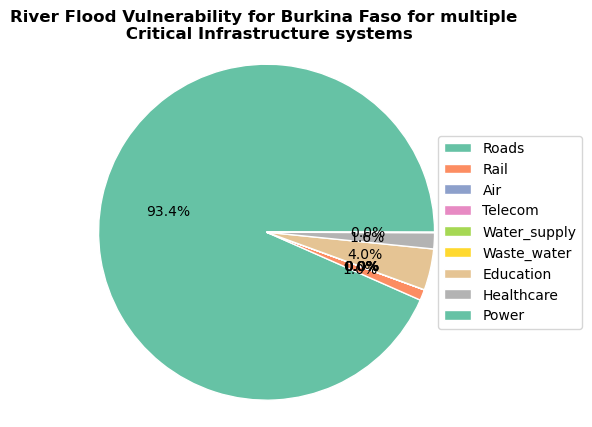

In [16]:
labels = [x.capitalize() for x in list(collect_damages.keys())]
sizes = collect_damages.values()
pie = plt.pie(sizes,autopct='%1.1f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);
plt.axis('equal')
plt.legend(loc = 'right', labels=labels,bbox_to_anchor=(1.15, 0.5),)
plt.title(f'River Flood Vulnerability for {country_full_name} for multiple \n Critical Infrastructure systems',fontweight='bold')